# ch 16_6 ARIMA parameters

이전 챕터에서 ARIMA 모델의 기본적인 개념을 배우고 임의의 파라미터를 설정하여 모델을 학습시켜 보았습니다. ARIMA 모델의 세 파라미터는 아래와 같습니다.

- p: AR 모델이 얼마나 이전 시점까지 고려할 것인가
- q: MA 모델이 얼마나 이전 시점까지 고려할 것인가
- d: 차분을 얼마나 적용할 것인가

이번 챕터에서는 ARIMA 모델을 학습시키기 위해서 필요한 p, d, q 파라미터를 선택하는 방법에 대해서 배워보겠습니다.

In [24]:
import warnings

warnings.filterwarnings(action='ignore')

## 데이터 셋 준비

In [25]:
from utils import load_air_passengers, calculate_rmse

train_df, test_df = load_air_passengers()

<Axes: xlabel='Month'>

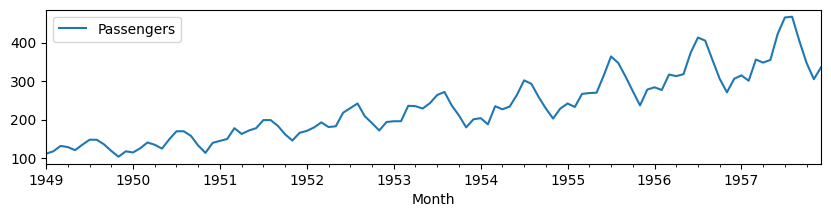

In [26]:
train_df.plot(figsize=(10, 2))

<Axes: xlabel='Month'>

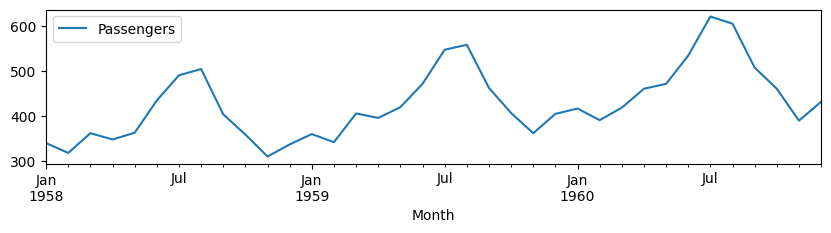

In [27]:
test_df.plot(figsize=(10, 2))

## 수작업으로 p, d, q 결정하기

### 차분 파라미터 d 결정

차분은 시계열 데이터를 stationary하게 만드는데 목적이 있습니다. 하지만 과도하게 차분하지 않도록 주의해야 합니다. 따라서 정상성을 확보하기 위한 최소한의 차분 정도를 결정해야 합니다. 차분 차원을 결정하는 데에는 몇가지 규칙을 적용할 수 있습니다.

- 많은 lag에 대해서 양의 자기 상관을 보인다면 차분이 더 필요하다.
- lag-1의 자기 상관이 0이거나 음수거나 크기가 작거나 패턴이 없으면 더 이상의 차분이 필요하지 않다.
- lag-1의 자기 상관이 -0.5보다 작은 음수라면 과도하게 차분된 것이다.
- 표준 편차가 가장 낮은 차분이 좋다.
- 차분 차수가 없는 모델은 원래 데이터가 정상성이라고 가정한다.
- 차분 차수가 1인 모델은 원래 데이터가 일정한 추세를 갖는다고 가정한다.
- 차분 차수가 2인 모델은 원래 데이터가 변화하는 추세를 갖는다고 가정한다.
- ACF 그래프가 급격하게 떨어지고, lag-1의 ACF 값이 음수이면 과도하게 차분된 것이다.
- PACF 그래프가 급격하게 떨어지고, lag-1의 PACF 값이 양수이면 덜 차분된 것이다. 

위 규칙과 adf test를 이용해서 차분 차수를 정해보겠습니다.

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

def differencing_plot(df, target_column):
    target_series = df[target_column].dropna()
    result = adfuller(target_series)
    p_value = result[1] 
    print(f"{target_column} adf p-value: {round(p_value, 4)} stationary: {p_value < 0.05}")
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    plot_acf(df[target_column].dropna(), ax=ax1);
    plot_pacf(df[target_column].dropna(), ax=ax2);

In [29]:
train_df["1D diff"] = train_df["Passengers"].diff()
train_df["2D diff"] = train_df["1D diff"].diff()

Passengers adf p-value: 0.9943 stationary: False


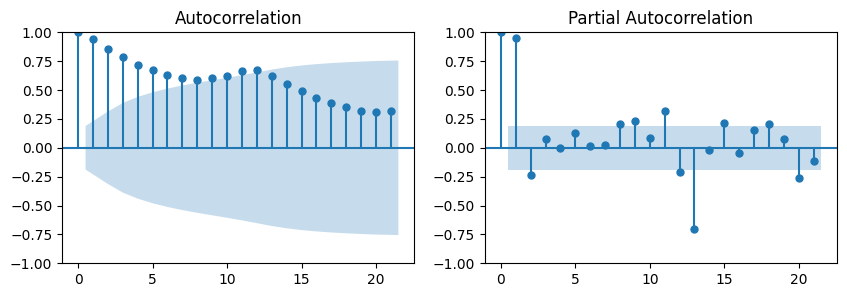

In [30]:
differencing_plot(train_df, "Passengers")

먼저 차분을 적용 안한 상태에서는 adf test를 통과하지 못합니다. ACF 또한 0으로 수렴하지 않아서 차분이 필요합니다. 

1D diff adf p-value: 0.1777 stationary: False


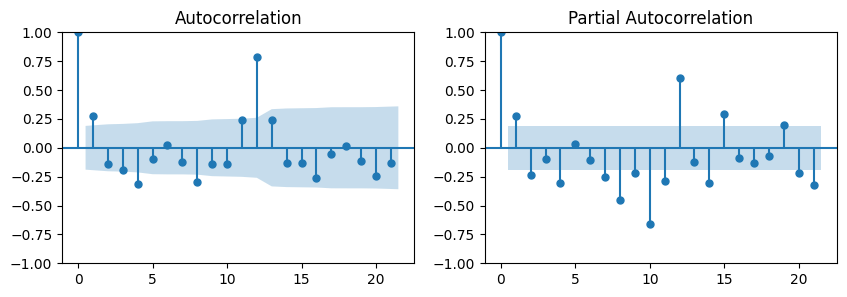

In [31]:
differencing_plot(train_df, "1D diff")

1차 차분 결과, adf test를 아직 통과하지 못했고 PACF 그래프의 lag-1 값이 양수입니다. 즉, 아직 덜 차분되었다고 볼 수 있습니다. 차분을 한번 더 적용해보고 결과를 비교해보겠습니다.

2D diff adf p-value: 0.0 stationary: True


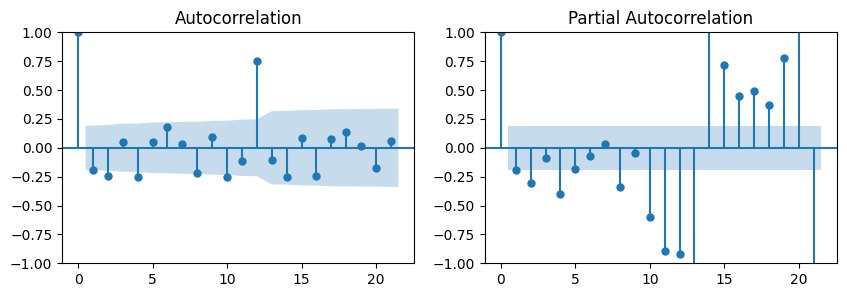

In [32]:
differencing_plot(train_df, "2D diff")

2차 차분 결과 adf test는 통과하였습니다만 p-value가 0이어서 과도하게 차분되었을 우려가 있습니다. ACF 그래프를 보면 lag-1의 AC 값이 음수이므로 더 이상 차분할 필요성은 없습니다. 그리고 lag-1 ACF 값이 음수기 때문에 과도하게 차분되었을 우려가 있습니다. 

이제 1차 차분을 할지, 2차 차분을 할지 결정해야합니다. 1차 차분은 adf test를 통과하지 못하여 데이터가 비정상성이라는 단점이 있고, 2차 차분은 과도하게 차분되었을 우려가 있습니다. 차분은 최소한의 수준으로 유지하는 것이 좋으므로 1차 차분을 선택하겠습니다.

### AR, MA 파라미터 p, q 결정하기

AR과 MA의 파라미터 p, q를 결정하기 위해서는 차분한 데이터로 ACF, PACF 그래프를 그려보면 됩니다.

1D diff adf p-value: 0.1777 stationary: False


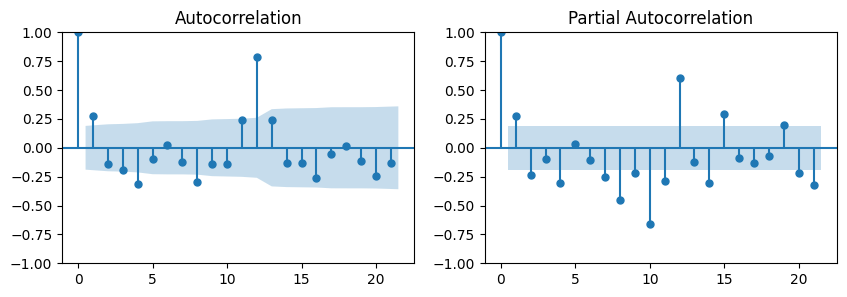

In [33]:
differencing_plot(train_df, "1D diff")

먼저 AR 모델의 파라미터 p를 결정하기 위해서는 PACF 플랏을 보면 됩니다. 유의 수준을 초과하는 lag들을 확인한 다음 적절한 p 값을 결정하면 됩니다. 여기서는 lag-2 까지 유의하다고 나왔으므로 2로 설정하겠습니다.

다음으로 MA 모델의 파라미터 q를 결정하기 위해서는 ACF 플랏을 보면 됩니다. ACF 그래프가 급격하게 꺾이는 부분을 q 값으로 설정해주면 되며, 여기서는 1로 지정하겠습니다. 

이 외에도 ARIMA 모델의 파라미터를 결정하는데 적용할 수 있는 규칙들과 이론들이 많습니다.더 궁금하신 분들은 아래 자료를 참고해주세요  
https://people.duke.edu/~rnau/411arim3.htm

### 파라미터 지정해서 AIRMA 학습

앞서 찾은 파라미터로 AIRMA 모델을 학습시키겠습니다.

In [34]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["Passengers"], order=(2, 1, 1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  108
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -486.590
Date:                Mon, 31 Jul 2023   AIC                            981.181
Time:                        15:58:06   BIC                            991.872
Sample:                    01-01-1949   HQIC                           985.515
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0506      0.107      9.849      0.000       0.842       1.260
ar.L2         -0.4606      0.112     -4.121      0.000      -0.680      -0.242
ma.L1         -0.8145      0.104     -7.800      0.000      -1.019      -0.610
sigma2       518.4064     70.145      7.390      0.000     380.924     655.888
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 7.89
Prob(Q):                              0.51   Prob(JB):                         0.02
Heteroskedasticity (H):               5.03   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
train_df["ARIMA"] = arima_model.predict()
test_df["ARIMA"] = arima_model.forecast(steps=len(test_df))

<Axes: xlabel='Month'>

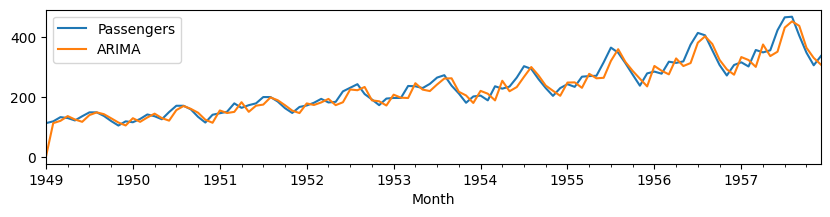

In [36]:
train_df[["Passengers", "ARIMA"]].plot(figsize=(10, 2))

<Axes: xlabel='Month'>

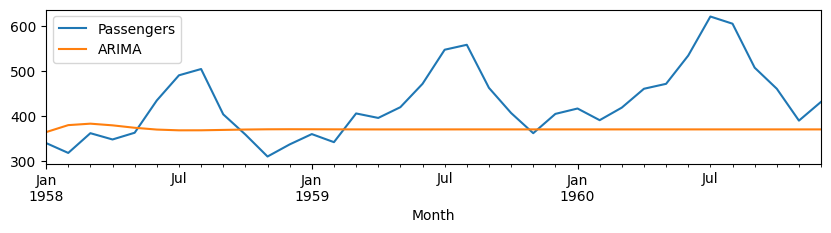

In [37]:
test_df[["Passengers", "ARIMA"]].plot(figsize=(10, 2))

### 성능 측정

육안으로 보더라도 test set에 대해서 ARIMA 모델이 제대로 예측값을 내려주지 못하는 모습을 볼 수 있습니다. 이는 Passengers 데이터 셋이 강한 계절성을 보여주지만, ARIMA 모델에는 계절성이 반영되지 않기 때문입니다. ARIMA 모델에 계절성을 추가한 SARIMA 모델을 선택하면 대폭 성능이 개선됩니다.

In [38]:
calculate_rmse(test_df, "Passengers", "ARIMA")

ARIMA RMSE: 97.82879475585801


## 자동으로 ARIMA 모델 파라미터 결정하기

직접 ACF와 PACF를 그려서 파라미터를 결정할 수도 있지만, 이를 자동화 해놓은 라이브러리를 사용하면 알아서 파라미터를 결정해서 AIRMA 모델을 학습시켜줍니다.

In [39]:
!pip install pmdarima


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


auto arima는 ACF, PACF를 보고 결정하는 휴리스틱 로직에 더해, 각 파라미터 조합으로 모델을 학습시키고 AIC를 측정하여 최적의 파라미터 조합을 결정하는 grid search가 추가되었습니다.

In [40]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(train_df["Passengers"], seasonal=False, trace=True)
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=983.832, Time=0.02 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 0.827 seco

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -473.609
Date:                Mon, 31 Jul 2023   AIC                            959.218
Time:                        15:58:12   BIC                            975.255
Sample:                    01-01-1949   HQIC                           965.719
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6708      0.207      3.235      0.001       0.264       1.077
ar.L1          1.6405      0.044     37.563      0.000       1.555       1.726
ar.L2         -0.9086      0.034    -26.746      0.000      -0.975      -0.842
ma.L1         -1.8338      0.047    -38.610      0.000      -1.927      -1.741
ma.L2          0.9289      0.047     19.917      0.000       0.838       1.020
sigma2       393.3179     69.406      5.667      0.000     257.286     529.350
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.44   Prob(JB):                         0.14
Heteroskedasticity (H):               4.42   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

auto arima를 통해서 찾은 파라미터는 (2, 1, 2) 입니다. 이를 이용해 예측값을 구한 다음, 성능을 비교해보겠습니다.

In [41]:
train_df["AUTO ARIMA"] = auto_arima_model.predict_in_sample()

<Axes: xlabel='Month'>

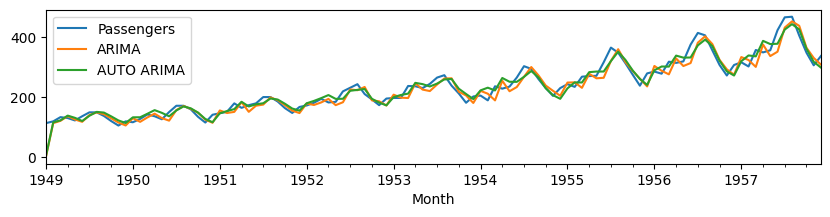

In [42]:
train_df[["Passengers", "ARIMA", "AUTO ARIMA"]].plot(figsize=(10, 2))

In [43]:
test_df["AUTO ARIMA"] = auto_arima_model.predict(n_periods=len(test_df))

<Axes: xlabel='Month'>

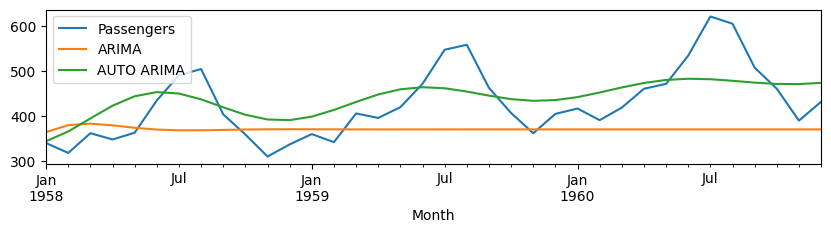

In [44]:
test_df[["Passengers", "ARIMA", "AUTO ARIMA"]].plot(figsize=(10, 2))

In [46]:
calculate_rmse(test_df, "Passengers", "ARIMA")
calculate_rmse(test_df, "Passengers", "AUTO ARIMA")

ARIMA RMSE: 97.82879475585801
AUTO ARIMA RMSE: 59.206158726932685


## 정리

이번 챕터에서는 대표적인 시계열 예측 모델인 ARIMA에 대해서 배웠습니다. ARIMA를 구성하는 기본 요소들과 파라미터의 의미에 대해서 알아보았습니다. 이어지는 챕터에서는 계절성을 띄는 데이터에 적용할 수 있는 ARIMA 모델의 변형인 SARIMA에 대해서 배워보겠습니다.